In [1]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    }
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

In [4]:
agg_strats = ['mean']

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

predictions = m_wrap.get_sub(aggregated=True)

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}


# Model 1

In [5]:
agg_strats = ['min','max']
rand_incr = 1
name = 'MinMax'

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg = m_wrap.get_sub(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(4):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=11,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_sub_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_sub_agg))

    predictions[f'{name}_{i}'] = pred_sub

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
0:	learn: 0.1542397	total: 130ms	remaining: 1m 44s
1:	learn: 0.1501884	total: 218ms	remaining: 1m 27s
2:	learn: 0.1461092	total: 300ms	remaining: 1m 19s
3:	learn: 0.1423707	total: 377ms	remaining: 1m 14s
4:	learn: 0.1384643	total: 464ms	remaining: 1m 13s
5:	learn: 0.1348549	total: 552ms	remaining: 1m 13s
6:	learn: 0.1313286	total: 621ms	remaining: 1m 10s
7:	learn: 0.1281157	total: 690ms	remaining: 1m 8s
8:	learn: 0.1250072	total: 773ms	remaining: 1m 7s
9:	learn: 0.1219157	total: 849ms	remaining: 1m 7s
10:	learn: 0.1188471	total: 918ms	remaining: 1m 5s
11:	learn: 0.1160579	total: 988ms	remaining: 1m 4s
12:	learn: 0.1133692	total: 1.06s	remaining: 1m 3s
13:	learn: 0.1106323	total: 1.14s	remaining: 1m 3s
14:	learn: 0.1080156	total: 1.21s	remaining: 1m 3s
15:	learn: 0.1055045	total: 1.29s	remaining: 1m 3s
16:	learn: 0.1030747	total: 1.4s	remaining: 1m 4s
17:	learn: 0.1007874	total: 1.49s	remaining: 1m 4s
18:	le

In [6]:
agg_strats = ['mean','std']
rand_incr = 2
name = 'MeanStd'

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg = m_wrap.get_sub(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(4):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=11,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_sub_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_sub_agg))

    predictions[f'{name}_{i}'] = pred_sub

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
0:	learn: 0.1543743	total: 67.6ms	remaining: 54s
1:	learn: 0.1503529	total: 139ms	remaining: 55.6s
2:	learn: 0.1463638	total: 206ms	remaining: 54.7s
3:	learn: 0.1427405	total: 274ms	remaining: 54.5s
4:	learn: 0.1389596	total: 341ms	remaining: 54.3s
5:	learn: 0.1354490	total: 410ms	remaining: 54.2s
6:	learn: 0.1319804	total: 475ms	remaining: 53.9s
7:	learn: 0.1285796	total: 541ms	remaining: 53.6s
8:	learn: 0.1252687	total: 608ms	remaining: 53.4s
9:	learn: 0.1220806	total: 674ms	remaining: 53.2s
10:	learn: 0.1190229	total: 740ms	remaining: 53s
11:	learn: 0.1161073	total: 808ms	remaining: 53s
12:	learn: 0.1133288	total: 877ms	remaining: 53.1s
13:	learn: 0.1107393	total: 943ms	remaining: 53s
14:	learn: 0.1082265	total: 1.01s	remaining: 52.9s
15:	learn: 0.1057060	total: 1.08s	remaining: 52.8s
16:	learn: 0.1033537	total: 1.16s	remaining: 53.4s
17:	learn: 0.1011371	total: 1.23s	remaining: 53.6s
18:	learn: 0.098846

In [7]:
agg_strats = ['mean','std','min','max','00','15','30','45']
rand_incr = 3
name = 'Everything'

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg = m_wrap.get_sub(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(4):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=11,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_sub_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_sub_agg))

    predictions[f'{name}_{i}'] = pred_sub

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
0:	learn: 0.1544584	total: 256ms	remaining: 3m 24s
1:	learn: 0.1502481	total: 500ms	remaining: 3m 19s
2:	learn: 0.1461831	total: 741ms	remaining: 3m 16s
3:	learn: 0.1423264	total: 975ms	remaining: 3m 14s
4:	learn: 0.1387339	total: 1.21s	remaining: 3m 12s
5:	learn: 0.1351095	total: 1.45s	remaining: 3m 11s
6:	learn: 0.1315204	total: 1.7s	remaining: 3m 12s
7:	learn: 0.1281501	total: 1.94s	remaining: 3m 12s
8:	learn: 0.1249139	total: 2.18s	remaining: 3m 11s
9:	learn: 0.1218339	total: 2.42s	remaining: 3m 11s
10:	learn: 0.1187606	total: 2.66s	remaining: 3m 10s
11:	learn: 0.1159278	total: 2.91s	remaining: 3m 11s
12:	learn: 0.1131382	total: 3.15s	remaining: 3m 10s
13:	learn: 0.1105209	total: 3.41s	remaining: 3m 11s
14:	learn: 0.1080802	total: 3.68s	remaining: 3m 12s
15:	learn: 0.1056173	total: 3.97s	remaining: 3m 14s
16:	learn: 0.1031332	total: 4.24s	remaining: 3m 15s
17:	learn: 0.1008187	total: 4.51s	remaining: 3m

In [8]:
predictions

,building_id,hourDayMonthYear,isEstimated,delta_forecast,date_forecast,dayMonthYear,monthYear,month,hour,mean_date_calc,mean_absolute_humidity_2m:gm3,mean_air_density_2m:kgm3,mean_ceiling_height_agl:m,mean_clear_sky_energy_1h:J,mean_clear_sky_rad:W,mean_cloud_base_agl:m,mean_dew_or_rime:idx,mean_dew_point_2m:K,mean_diffuse_rad:W,mean_diffuse_rad_1h:J,mean_direct_rad:W,mean_direct_rad_1h:J,mean_effective_cloud_cover:p,mean_elevation:m,mean_fresh_snow_12h:cm,mean_fresh_snow_1h:cm,mean_fresh_snow_24h:cm,mean_fresh_snow_3h:cm,mean_fresh_snow_6h:cm,mean_is_day:idx,mean_is_in_shadow:idx,mean_msl_pressure:hPa,mean_precip_5min:mm,mean_precip_type_5min:idx,mean_pressure_100m:hPa,mean_pressure_50m:hPa,mean_prob_rime:p,mean_rain_water:kgm2,mean_relative_humidity_1000hPa:p,mean_sfc_pressure:hPa,mean_snow_density:kgm3,mean_snow_depth:cm,mean_snow_drift:idx,mean_snow_melt_10min:mm,mean_snow_water:kgm2,mean_sun_azimuth:d,mean_sun_elevation:d,mean_super_cooled_liquid_water:kgm2,mean_t_1000hPa:K,mean_total_cloud_cover:p,mean_visibility:m,mean_wind_speed_10m:ms,mean_wind_speed_u_10m:ms,mean_wind_speed_v_10m:ms,mean_wind_speed_w_1000hPa:ms,mean_GHI,mean_wind_angle,mean_temp*GHI,mean_wind*humidity,mean_sun_height*diff_rad,mean_wind_angle_sin,mean_wind_angle_cos,mean_hour_sin,mean_hour_cos,mean_GHI_daily_mean,mean_GHI_daily_std,mean_effective_cloud_cover_5h_mean,mean_GHI_lag_-1h,mean_GHI_lag_1h,mean_temp*GHI_lag_-1h,mean_temp*GHI_lag_1h,MinMax_0,MinMax_1,MinMax_2,MinMax_3,MeanStd_0,MeanStd_1,MeanStd_2,MeanStd_3,Everything_0,Everything_1,Everything_2,Everything_3
0,a,2023-05-01 00:00:00,1,16.998889,2023-05-01 00:00:00,2023-05-01,2023-05,5,0,2023-04-30 07:00:04,4.325,1.28675,912.700012,0.000000,0.000000,1061.550049,0.0,271.650024,0.000000,0.000000,0.000000,0.000000,74.949997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.674988,0.0,0.0,1000.549988,1006.799988,0.0,0.0,80.275002,1013.099976,NaN,0.0,0.0,0.0,0.0,16.026501,-10.541000,0.000,273.799988,74.949997,29907.500000,3.950,2.100,3.350,0.0,0.000000,0.559798,0.000000,317.087524,0.000000,0.530980,0.847307,0.000000,1.000000,202.039597,198.742325,NaN,0.000000,NaN,0.000000,NaN,-0.037263,9.624809,-0.047704,-0.043495,-0.033573,0.028712,-0.033686,-0.825241,1.070161,0.123300,0.022115,-0.000313
1,a,2023-05-01 01:00:00,1,17.998889,2023-05-01 01:00:00,2023-05-01,2023-05,5,1,2023-04-30 07:00:04,4.275,1.28600,1482.099976,0.000000,0.000000,1075.100098,0.0,271.450012,0.000000,0.000000,0.000000,0.000000,77.474998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.150024,0.0,0.0,1000.049988,1006.299988,0.0,0.0,79.824997,1012.599976,NaN,0.0,0.0,0.0,0.0,30.497250,-7.894500,0.000,273.799988,77.474998,29519.074219,3.825,1.925,3.300,0.0,0.000000,0.528019,0.000000,305.339996,0.000000,0.503799,0.863766,0.258819,0.965926,202.039597,198.742325,NaN,0.000000,0.000000,0.000000,0.000000,-0.024613,0.160708,-0.214553,-0.259998,0.027936,0.023006,-0.039283,-0.664621,0.029379,-0.030143,0.014407,0.082309
2,a,2023-05-01 02:00:00,1,18.998889,2023-05-01 02:00:00,2023-05-01,2023-05,5,2,2023-04-30 07:00:04,4.150,1.28375,1791.300049,0.000000,0.000000,1200.400024,0.0,271.049988,0.000000,0.000000,0.000000,0.000000,88.099998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1012.674988,0.0,0.0,999.500000,1005.799988,0.0,0.0,78.000000,1012.049988,NaN,0.0,0.0,0.0,0.0,44.517250,-3.815500,0.000,273.849976,88.099998,31009.125000,3.650,1.750,3.200,0.0,0.000000,0.500362,0.000000,284.739990,0.000000,0.479708,0.877346,0.500000,0.866025,202.039597,198.742325,75.042500,11.475000,0.000000,3143.002441,0.000000,1.322306,2.087457,-0.355704,2.753846,-1.305262,-8.801817,0.904878,-1.742879,2.256410,0.287245,0.498713,-2.016822
3,a,2023-05-01 03:00:00,1,19.998889,2023-05-01 03:00:00,2023-05-01,2023-05,5,3,2023-04-30 07:00:04,4.025,1.28200,2312.875000,10124.424805,11.675000,1179.849976,0.0,270.649994,9.375000,16845.226562,2.100000,3765.350098,68.599998,6.0,0.0,0.0,0.0,0.0,0.0,0.75,0.5,1012.174988,0.0,0.0,998.974976,1005.224976,0.0,0.0,75.625000,1011.525024,NaN,0.0,0.0,0.0,0.0,58.083000,1.412500,0.000,27

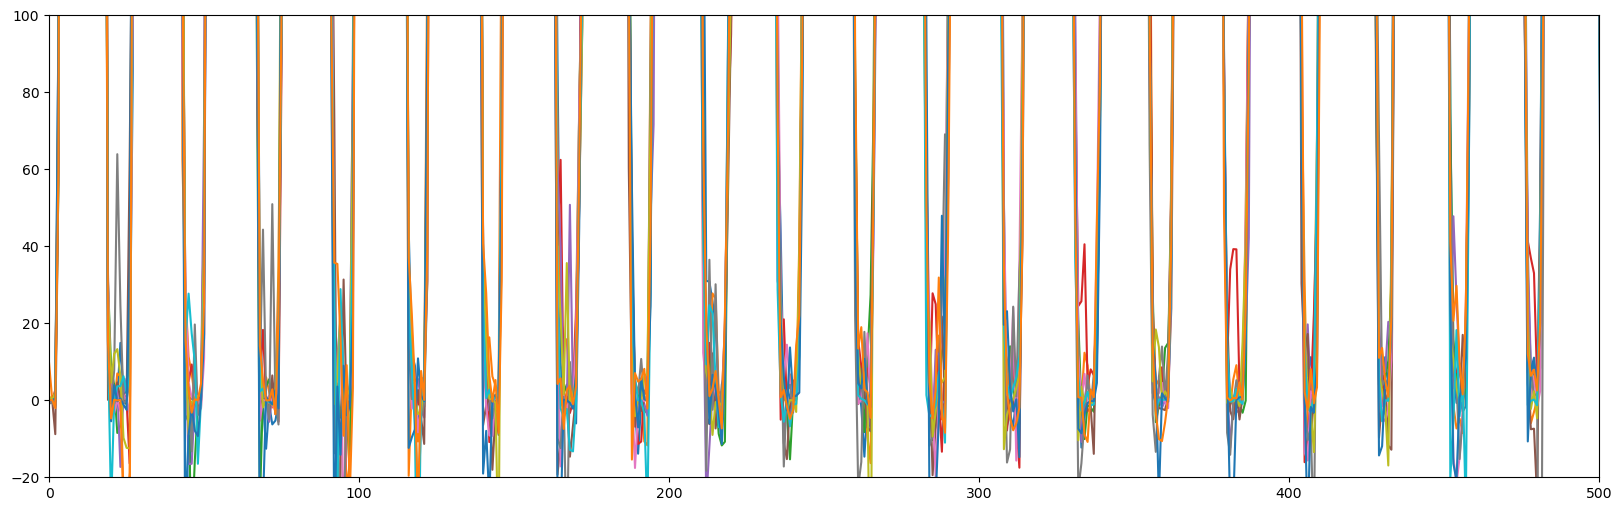

In [9]:
pred_only_pred = predictions.iloc[:,-12:]
plt.figure(figsize=(20,6))
plt.xlim(0,500)
plt.ylim(-20,100)
plt.plot(pred_only_pred);

In [10]:
predictions

,building_id,hourDayMonthYear,isEstimated,delta_forecast,date_forecast,dayMonthYear,monthYear,month,hour,mean_date_calc,mean_absolute_humidity_2m:gm3,mean_air_density_2m:kgm3,mean_ceiling_height_agl:m,mean_clear_sky_energy_1h:J,mean_clear_sky_rad:W,mean_cloud_base_agl:m,mean_dew_or_rime:idx,mean_dew_point_2m:K,mean_diffuse_rad:W,mean_diffuse_rad_1h:J,mean_direct_rad:W,mean_direct_rad_1h:J,mean_effective_cloud_cover:p,mean_elevation:m,mean_fresh_snow_12h:cm,mean_fresh_snow_1h:cm,mean_fresh_snow_24h:cm,mean_fresh_snow_3h:cm,mean_fresh_snow_6h:cm,mean_is_day:idx,mean_is_in_shadow:idx,mean_msl_pressure:hPa,mean_precip_5min:mm,mean_precip_type_5min:idx,mean_pressure_100m:hPa,mean_pressure_50m:hPa,mean_prob_rime:p,mean_rain_water:kgm2,mean_relative_humidity_1000hPa:p,mean_sfc_pressure:hPa,mean_snow_density:kgm3,mean_snow_depth:cm,mean_snow_drift:idx,mean_snow_melt_10min:mm,mean_snow_water:kgm2,mean_sun_azimuth:d,mean_sun_elevation:d,mean_super_cooled_liquid_water:kgm2,mean_t_1000hPa:K,mean_total_cloud_cover:p,mean_visibility:m,mean_wind_speed_10m:ms,mean_wind_speed_u_10m:ms,mean_wind_speed_v_10m:ms,mean_wind_speed_w_1000hPa:ms,mean_GHI,mean_wind_angle,mean_temp*GHI,mean_wind*humidity,mean_sun_height*diff_rad,mean_wind_angle_sin,mean_wind_angle_cos,mean_hour_sin,mean_hour_cos,mean_GHI_daily_mean,mean_GHI_daily_std,mean_effective_cloud_cover_5h_mean,mean_GHI_lag_-1h,mean_GHI_lag_1h,mean_temp*GHI_lag_-1h,mean_temp*GHI_lag_1h,MinMax_0,MinMax_1,MinMax_2,MinMax_3,MeanStd_0,MeanStd_1,MeanStd_2,MeanStd_3,Everything_0,Everything_1,Everything_2,Everything_3
0,a,2023-05-01 00:00:00,1,16.998889,2023-05-01 00:00:00,2023-05-01,2023-05,5,0,2023-04-30 07:00:04,4.325,1.28675,912.700012,0.000000,0.000000,1061.550049,0.0,271.650024,0.000000,0.000000,0.000000,0.000000,74.949997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.674988,0.0,0.0,1000.549988,1006.799988,0.0,0.0,80.275002,1013.099976,NaN,0.0,0.0,0.0,0.0,16.026501,-10.541000,0.000,273.799988,74.949997,29907.500000,3.950,2.100,3.350,0.0,0.000000,0.559798,0.000000,317.087524,0.000000,0.530980,0.847307,0.000000,1.000000,202.039597,198.742325,NaN,0.000000,NaN,0.000000,NaN,-0.037263,9.624809,-0.047704,-0.043495,-0.033573,0.028712,-0.033686,-0.825241,1.070161,0.123300,0.022115,-0.000313
1,a,2023-05-01 01:00:00,1,17.998889,2023-05-01 01:00:00,2023-05-01,2023-05,5,1,2023-04-30 07:00:04,4.275,1.28600,1482.099976,0.000000,0.000000,1075.100098,0.0,271.450012,0.000000,0.000000,0.000000,0.000000,77.474998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.150024,0.0,0.0,1000.049988,1006.299988,0.0,0.0,79.824997,1012.599976,NaN,0.0,0.0,0.0,0.0,30.497250,-7.894500,0.000,273.799988,77.474998,29519.074219,3.825,1.925,3.300,0.0,0.000000,0.528019,0.000000,305.339996,0.000000,0.503799,0.863766,0.258819,0.965926,202.039597,198.742325,NaN,0.000000,0.000000,0.000000,0.000000,-0.024613,0.160708,-0.214553,-0.259998,0.027936,0.023006,-0.039283,-0.664621,0.029379,-0.030143,0.014407,0.082309
2,a,2023-05-01 02:00:00,1,18.998889,2023-05-01 02:00:00,2023-05-01,2023-05,5,2,2023-04-30 07:00:04,4.150,1.28375,1791.300049,0.000000,0.000000,1200.400024,0.0,271.049988,0.000000,0.000000,0.000000,0.000000,88.099998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1012.674988,0.0,0.0,999.500000,1005.799988,0.0,0.0,78.000000,1012.049988,NaN,0.0,0.0,0.0,0.0,44.517250,-3.815500,0.000,273.849976,88.099998,31009.125000,3.650,1.750,3.200,0.0,0.000000,0.500362,0.000000,284.739990,0.000000,0.479708,0.877346,0.500000,0.866025,202.039597,198.742325,75.042500,11.475000,0.000000,3143.002441,0.000000,1.322306,2.087457,-0.355704,2.753846,-1.305262,-8.801817,0.904878,-1.742879,2.256410,0.287245,0.498713,-2.016822
3,a,2023-05-01 03:00:00,1,19.998889,2023-05-01 03:00:00,2023-05-01,2023-05,5,3,2023-04-30 07:00:04,4.025,1.28200,2312.875000,10124.424805,11.675000,1179.849976,0.0,270.649994,9.375000,16845.226562,2.100000,3765.350098,68.599998,6.0,0.0,0.0,0.0,0.0,0.0,0.75,0.5,1012.174988,0.0,0.0,998.974976,1005.224976,0.0,0.0,75.625000,1011.525024,NaN,0.0,0.0,0.0,0.0,58.083000,1.412500,0.000,27

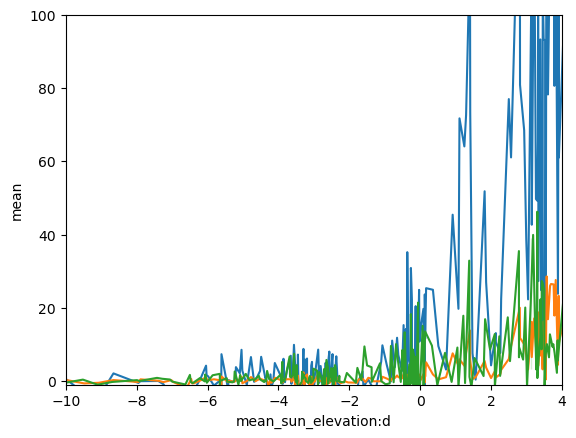

In [11]:
predictions['mean'] = pred_only_pred.mean(axis=1)
plt.xlim(-10,4)
plt.ylim(-1,100)
sns.lineplot(data=predictions, x='mean_sun_elevation:d', y='mean', hue='building_id', legend=False);

In [12]:
predictions['mean'] = predictions['mean'].clip(0)
predictions.loc[predictions['mean_sun_elevation:d'] <-1,'mean'] = 0

In [15]:
predictions['mean'].to_csv('catBoost_ensemble_11.csv', index=True)

In [14]:
cat = pd.read_csv('submission_files/151_90043_feature_extraction2_scaled_tuned_depth13.csv')['prediction'].to_list()

predictions.append(cat)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

data_root = 'https://autogluon.s3.amazonaws.com/datasets/Inc/'
train_data = TabularDataset(data_root + 'train.csv')
test_data = TabularDataset(data_root + 'test.csv')

predictor = TabularPredictor(label='class').fit(train_data=train_data)
predictions = predictor.predict(test_data)

# Ideas
Bagging:
    - building
    - hour / sun elevation
    - (sunny day)
Stacking
    - xgboost, random forest, catboost, lightgbm
    - different aggregations
        - max, min
        - time values
        - mean, std
        - (everything)
    - random seed

# Combine Predictions

In [ ]:


predictions

array_preds = np.array(predictions)
predictions_mean = pd.Series(np.average(array_preds,axis=0))

In [ ]:
predictions_mean.loc[X_sub_agg['min_sun_elevation:d'] < -1] = 0

predictions_mean.to_csv('submission_files/ensemble.csv',index=True)

In [ ]:

m_wrap.y_pred_to_csv(predictions_mean, X_sub_agg, is_aggregated=True,name='ensemble.csv',sun_el_thr=-5)

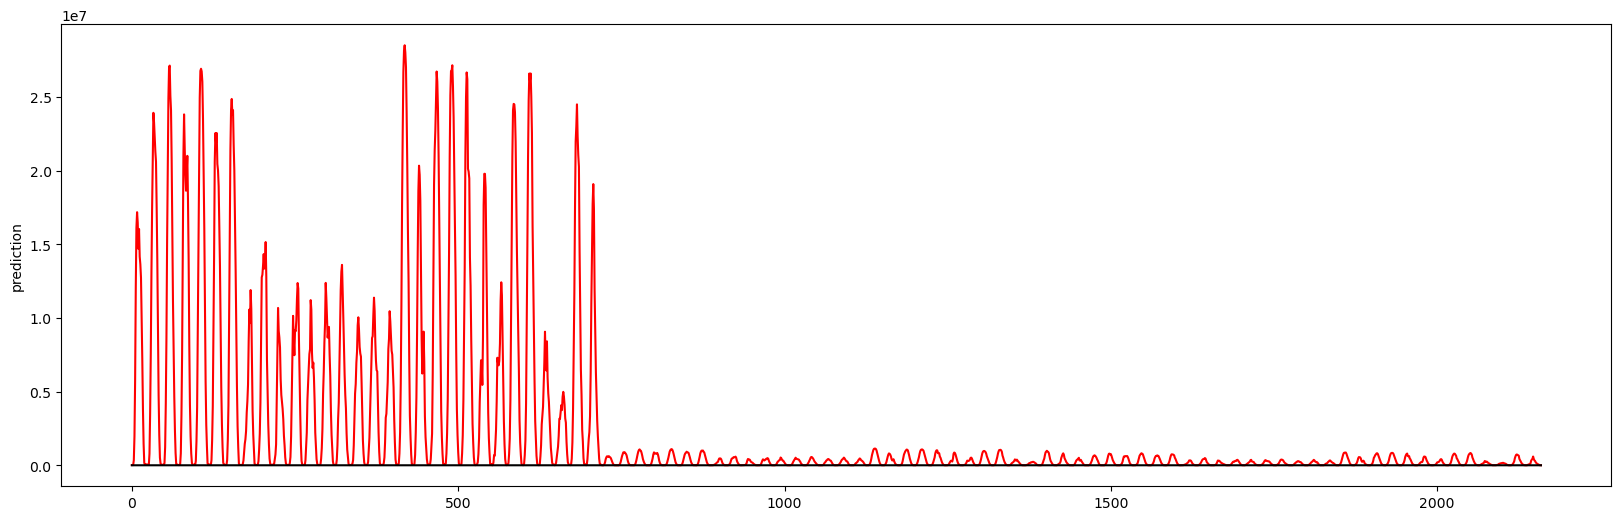

KeyError: 'hourDayMonthYear'

In [ ]:
m_wrap.plot_yPredSub_vs_submission(predictions_mean, X_sub_agg)
m_wrap.y_pred_to_csv(predictions_mean,X_train_agg,True,'building_bagging.csv',1)

In [ ]:
predictions_mean

0    274.467289
dtype: float64